# **Q1: Implement Automatic Differentiation Engine**

For this assignment, you'll create a fundamental automatic differentiation engine from scratch. We'll initially focus on scalar values to simplify the implementation, but the underlying concepts can be extended to tensors. Subsequently, use your custom differentiation engine to train a neural network entirely from scratch.

This assignment delves into the core concepts of backpropagation by building your own automatic differentiation engine. By implementing it from scratch, you'll gain a deeper appreciation for its elegance and efficiency.  You'll see how the object-oriented approach simplifies the construction and manipulation of the computational graph, revealing that it's not as complex as it might seem. The implementation for the automatic differentiation engine resides in a single file: `Q1/utils/engine.py`

Please refer this [video](https://youtu.be/d14TUNcbn1k?si=wc0Jd4gxw35Xr1L1) to learn more about backpropagation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Let's start building our differentiation engine!** Open the file `Q1/utils/engine.py`. This file defines the `Value` class, which acts as the basic unit of computation. It stores a single scalar value and its corresponding gradient. Your task is to implement the backward pass functionality within the `_backward()` function for this `Value` class. We'll use this to calculate gradients for basic operations like addition, multiplication, exponentiation, and ReLU activation. Finally, we'll leverage these functionalities to implement and train a neural network.

Specifically, your task is to write the code for the `_backward()` function within the provided code snippets.** Replace the `pass` statement with your code that calculates the expressions for `other.grad` and `self.grad` for each operation: addition (`__add__`), multiplication (`__mul__`), exponentiation (`__pow__`), and ReLU activation (`__relu__`).

Here's an example for the addition operation (`__add__`):

```python
def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        ####################################################################
        # TODO: Implement the addition backward pass.                      #
        ####################################################################
        # Replace "pass" statement with your code
        pass
        #####################################################################
        #                          END OF YOUR CODE                         #
        #####################################################################
    out._backward = _backward

    return out

```

Follow a similar approach to define the backward pass calculations for multiplication, exponentiation, and ReLU within their respective functions.


Next, implement the main `backward()` function, which will be called on the loss scalar value. This function performs a topological sort of all operation nodes and accumulates the gradients of these nodes with respect to the loss. The code for topological sorting is already provided. Your task is to use the sorted nodes and accumulate the gradients in each node by calling the `_backward()` function.

Run the cell below to verify your implementation. You can also check the tests in the `Q1/test/test_engine.py` file for further confirmation.

In [3]:
from test.test_engine import *

test_sanity_check()
test_more_ops()

In [4]:
from utils.engine import Value

**Now that the differentiation engine is operational, let's leverage it to build our neural network!** Open the file `Q1/utils/nn.py`. Implement the forward pass functionalities for `Neuron`, `Layer`, and `MLP` classes using the `Value` class as the building block. This approach will automatically provide gradient computations during the forward pass.

In [5]:
from utils.nn import Neuron, Layer, MLP

We now have all the necessary components to train a neural network. It's surprisingly simple to code up a neural network. However, scaling it to larger datasets requires leveraging matrix operations for parallelization and GPU acceleration. While this involves significant engineering, the underlying fundamental concepts remain unchanged.

Run the cells below to train the neural network on a toy dataset.

In [6]:
np.random.seed(1337)
random.seed(1337)

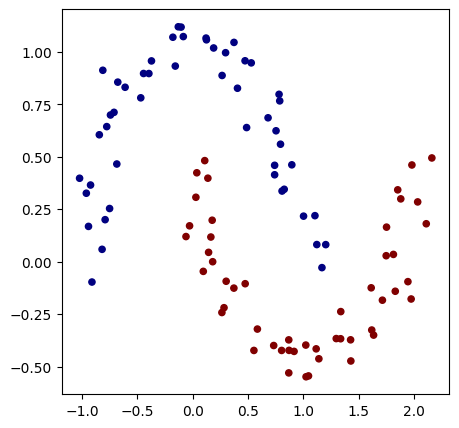

In [7]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [8]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

#changes below
x = [2.0, 3.0]
model(x)


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


Value(data=-1.9960862482990058, grad=0)

In [9]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [10]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976537, accuracy 84.0%
step 5 loss 0.31354548191852194, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658047, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192295, accuracy 91.0%
step 13 loss 0.23090378446402723, accuracy 93.0%
step 14 loss 0.2015215122789945, accuracy 92.0%
step 15 loss 0.22574506279282228, accuracy 93.0%
step 16 loss 0.19447987596204108, accuracy 92.0%
step 17 loss 0.21089496199246363, accuracy 93.0%
step 18 loss 0.15983077356303604, accuracy 94.0%
step 19 loss 0.18453748746883922, accuracy 93.0%
step 20 loss 0.1897752285608764, accura

(-1.548639298268643, 1.951360701731357)

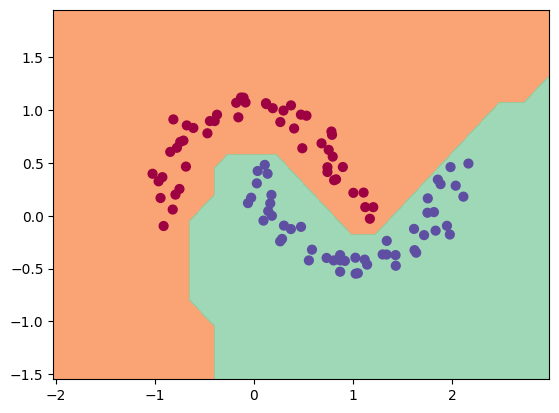

In [11]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
